User Experience Analysis

In [2]:

#Module Imports
import pickle
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings

import sys, os
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from plotting import PlotDataFrame
from utils import Util
warnings.filterwarnings('ignore')

Data Reading

In [4]:
#Initialize Plot
my_plt = PlotDataFrame()

df_tele = pd.read_csv("../data/cleaned_tele_data.csv")
df_tele.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146887 entries, 0 to 146886
Data columns (total 55 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Unnamed: 0                        146887 non-null  int64  
 1   Bearer Id                         146887 non-null  int64  
 2   Start                             146887 non-null  object 
 3   Start ms                          146887 non-null  float64
 4   End                               146887 non-null  object 
 5   End ms                            146887 non-null  float64
 6   IMSI                              146887 non-null  int64  
 7   MSISDN/Number                     146887 non-null  int64  
 8   IMEI                              146887 non-null  int64  
 9   Last Location Name                146887 non-null  object 
 10  Avg RTT DL (ms)                   146887 non-null  float64
 11  Avg RTT UL (ms)                   146887 non-null  f

User Experience Metrics

In [5]:
# Select Necessary Columns
df_tele_user_experience = df_tele[[
    'MSISDN/Number',
    'Avg RTT DL (ms)',
    'Avg RTT UL (ms)',
    'Avg Bearer TP DL (kbps)',
    'Avg Bearer TP UL (kbps)',
    'TCP DL Retrans. Vol (Bytes)',
    'TCP UL Retrans. Vol (Bytes)',
    'Handset Type']]
df_tele_user_experience


,MSISDN/Number,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),Handset Type
0,33664962239,42.0,5.0,23.0,44.0,19520.0,7230.0,Samsung Galaxy A5 Sm-A520F
1,33681854413,65.0,5.0,16.0,26.0,19520.0,7230.0,Samsung Galaxy J5 (Sm-J530)
2,33760627129,65.0,5.0,6.0,9.0,19520.0,7230.0,Samsung Galaxy A8 (2018)
3,33750343200,65.0,5.0,44.0,44.0,19520.0,7230.0,undefined
4,33699795932,65.0,5.0,6.0,9.0,19520.0,7230.0,Samsung Sm-G390F
...,...,...,...,...,...,...,...,...
146882,33762146363,27.0,2.0,62.0,54.0,7658052.5,162614.0,Apple iPhone 6S Plus (A1687)
146883,33761274518,37.0,4.0,23.0,40.0,7658052.5,162614.0,Apple iPhone 6S (A1688)
146884,33626114091,46.0,6.0,43.0,41.0,7658052.5,162614.0,Apple iPhone Xr (A2105)
146885,33645655643,46.0,6.0,55.0,54.0,7658052.5,162614.0,Samsung Galaxy J5 (Sm-J530)


In [6]:
#Caluclating the totals
df_tele_user_experience['Total Avg RTT (ms)'] = df_tele_user_experience['Avg RTT DL (ms)'] + df_tele_user_experience['Avg RTT UL (ms)']
df_tele_user_experience['Total Avg Bearer TP (kbps)'] = df_tele_user_experience['Avg Bearer TP DL (kbps)'] + df_tele_user_experience['Avg Bearer TP UL (kbps)']
df_tele_user_experience['Total TCP Retrans. Vol (Bytes)'] = df_tele_user_experience['TCP DL Retrans. Vol (Bytes)'] + df_tele_user_experience['TCP UL Retrans. Vol (Bytes)']
df_tele_user_experience.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146887 entries, 0 to 146886
Data columns (total 11 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   MSISDN/Number                   146887 non-null  int64  
 1   Avg RTT DL (ms)                 146887 non-null  float64
 2   Avg RTT UL (ms)                 146887 non-null  float64
 3   Avg Bearer TP DL (kbps)         146887 non-null  float64
 4   Avg Bearer TP UL (kbps)         146887 non-null  float64
 5   TCP DL Retrans. Vol (Bytes)     146887 non-null  float64
 6   TCP UL Retrans. Vol (Bytes)     146887 non-null  float64
 7   Handset Type                    146887 non-null  object 
 8   Total Avg RTT (ms)              146887 non-null  float64
 9   Total Avg Bearer TP (kbps)      146887 non-null  float64
 10  Total TCP Retrans. Vol (Bytes)  146887 non-null  float64
dtypes: float64(9), int64(1), object(1)
memory usage: 12.3+ MB


Aggregating

In [7]:
#aggregating data in the DataFrame df_tele_user_experience based on the 'MSISDN/Number' column. 
df_tele_user_experience_agg = df_tele_user_experience.groupby(
    'MSISDN/Number').agg({
        'Total Avg RTT (ms)': 'sum',
        'Total Avg Bearer TP (kbps)': 'sum',
        'Total TCP Retrans. Vol (Bytes)': 'sum',
        'Handset Type': [lambda x: x.mode()[0]]})
df_tele_user_experience_agg.head()

,Total Avg RTT (ms),Total Avg Bearer TP (kbps),Total TCP Retrans. Vol (Bytes),Handset Type
,sum,sum,sum,<lambda>
MSISDN/Number,,,,
33601001722,46.0,76.0,2895381.0,Huawei P20 Lite Huawei Nova 3E
33601001754,31.0,99.0,7685875.5,Apple iPhone 7 (A1778)
33601002511,59.0,97.0,4150403.0,undefined
33601007832,84.0,248.0,2396.0,Apple iPhone 5S (A1457)
33601008617,119.0,43204.5,8047304.5,Apple iPhone Se (A1723)


In [9]:
#Creating and Loading to a new aggregating dataframe
df_tele_user_experience_agg_new = pd.DataFrame(columns=[
    "Total Avg RTT (ms)",
    "Total Avg Bearer TP (kbps)",
    "Total TCP Retrans. Vol (Bytes)",
    "Handset Type"])

df_tele_user_experience_agg_new["Total Avg RTT (ms)"] = df_tele_user_experience_agg["Total Avg RTT (ms)"]['sum']
df_tele_user_experience_agg_new["Total Avg Bearer TP (kbps)"] = df_tele_user_experience_agg["Total Avg Bearer TP (kbps)"]['sum']
df_tele_user_experience_agg_new["Total TCP Retrans. Vol (Bytes)"] = df_tele_user_experience_agg["Total TCP Retrans. Vol (Bytes)"]['sum']
df_tele_user_experience_agg_new["Handset Type"] = df_tele_user_experience_agg["Handset Type"]['<lambda>']
df_tele_user_experience_agg_new.head()  


,Total Avg RTT (ms),Total Avg Bearer TP (kbps),Total TCP Retrans. Vol (Bytes),Handset Type
MSISDN/Number,,,,
33601001722,46.0,76.0,2895381.0,Huawei P20 Lite Huawei Nova 3E
33601001754,31.0,99.0,7685875.5,Apple iPhone 7 (A1778)
33601002511,59.0,97.0,4150403.0,undefined
33601007832,84.0,248.0,2396.0,Apple iPhone 5S (A1457)
33601008617,119.0,43204.5,8047304.5,Apple iPhone Se (A1723)


Top 10, Bottom 10 and Most Frequent Values Of The Experience Metrics

In [24]:
#Top And Bottom 10, Most Frequent TCP Values
tele_tcp = df_tele_user_experience_agg_new.sort_values('Total TCP Retrans. Vol (Bytes)', ascending=False)
# top_10 = tele_tcp.head(10)['Total TCP Retrans. Vol (Bytes)']
top_10 = tele_tcp.head(10)['Total TCP Retrans. Vol (Bytes)']
top_10

MSISDN/Number
33604515716    55343222.0
33665639832    53700625.5
33699231421    46949547.0
33660214653    46833154.0
33760112066    46772259.0
33665778430    46676014.0
33659822913    46615481.0
33699248832    46339810.0
33763730582    46241985.0
33658162536    46221159.0
Name: Total TCP Retrans. Vol (Bytes), dtype: float64

In [25]:
bottom_10 = tele_tcp.tail(10)['Total TCP Retrans. Vol (Bytes)']
bottom_10

MSISDN/Number
33648157044    97.0
33650128412    97.0
33603891144    97.0
33761446809    97.0
33665571059    97.0
33698289923    97.0
33650676273    97.0
33664156978    97.0
33669388268    92.0
33662545528    51.0
Name: Total TCP Retrans. Vol (Bytes), dtype: float64

In [26]:
most_10 = df_tele_user_experience_agg_new['Total TCP Retrans. Vol (Bytes)'].value_counts().head(10)
most_10

Total TCP Retrans. Vol (Bytes)
7824924.5     4187
7659346.5      263
15649849.0     244
7659382.5      104
1432.0          89
985475.0        81
115067.0        80
1441.0          70
1328130.0       69
1332524.0       67
Name: count, dtype: int64

Top 10, Bottom 10 and Most Frequent Values of Throughput 


In [33]:
tele_tp = df_tele_user_experience_agg_new.sort_values('Total Avg Bearer TP (kbps)', ascending=False)
top_10 = tele_tp.head(10)['Total Avg Bearer TP (kbps)']
top_10



MSISDN/Number
33762333464    445187.0
33659546392    420988.5
33614892860    377028.0
33659359429    362374.0
33662780927    328354.0
33604515716    319793.0
33699248832    316590.0
33699327554    315524.0
33658263267    314988.0
33658946065    311781.0
Name: Total Avg Bearer TP (kbps), dtype: float64

In [34]:
most_10 = df_tele_user_experience_agg_new['Total Avg Bearer TP (kbps)'].value_counts().head(10)
most_10

Total Avg Bearer TP (kbps)
15.0       2688
52765.0    2664
63.0       2074
97.0       1024
90.0       1005
98.0        969
96.0        865
99.0        852
89.0        815
95.0        798
Name: count, dtype: int64

In [35]:
most_10 = df_tele_user_experience_agg_new['Total Avg Bearer TP (kbps)'].value_counts().head(10)
most_10

Total Avg Bearer TP (kbps)
15.0       2688
52765.0    2664
63.0       2074
97.0       1024
90.0       1005
98.0        969
96.0        865
99.0        852
89.0        815
95.0        798
Name: count, dtype: int64

Distribution Of The Average Throughput Per Handset Type.

In [38]:
df_tele_handset_type = df_tele_user_experience_agg_new.groupby('Handset Type').mean()
df_tele_handset_type.head()

,Total Avg RTT (ms),Total Avg Bearer TP (kbps),Total TCP Retrans. Vol (Bytes)
Handset Type,,,
A-Link Telecom I. Cubot A5,42.0,23510.0,7673105.5
A-Link Telecom I. Cubot Note Plus,129.0,6699.0,616213.0
A-Link Telecom I. Cubot Note S,125.0,8937.0,7725304.5
A-Link Telecom I. Cubot Nova,44.0,50545.5,137170.0
A-Link Telecom I. Cubot Power,43.0,50337.5,8041.0


In [39]:
#Top handset_type based on the 'Total Avg Bearer TP (kbps)' 
df_tele_handset_tp = df_tele_handset_type.sort_values(
    'Total Avg Bearer TP (kbps)', ascending=False)
df_tele_handset_tp.head()


,Total Avg RTT (ms),Total Avg Bearer TP (kbps),Total TCP Retrans. Vol (Bytes)
Handset Type,,,
Huawei Par-Lx9,213.500000,127454.0,2896635.0
Spa Condor Elect. Allure M2,90.000000,102025.0,89016.0
Asustek Wireless-Ac1200 Lte Router,207.000000,79401.0,1309468.5
Lg-H860,90.000000,79107.5,7691178.5
Huawei B618S-22D,262.333333,78003.5,8259718.0


Average TCP Retransmission View Per Handset Type.

In [40]:
#Top handset_type based on TCP Retransmission' 

df_tele_handset_tcp = df_tele_handset_type.sort_values(
    'Total TCP Retrans. Vol (Bytes)', ascending=False)
df_tele_handset_tcp.head()


,Total Avg RTT (ms),Total Avg Bearer TP (kbps),Total TCP Retrans. Vol (Bytes)
Handset Type,,,
Sierra Wireless Usb305,245.00,31440.0,15649849.00
Huawei Me909S-120,208.00,1548.5,14731406.75
Sfr Star Trail 5 By Sfr,265.00,9718.0,9822653.50
Huawei B715S-23C,119.25,64984.9,8784713.15
Wistron Wnc D18Qx,217.00,3446.0,8707483.50


Handling Outliers

<Axes: >

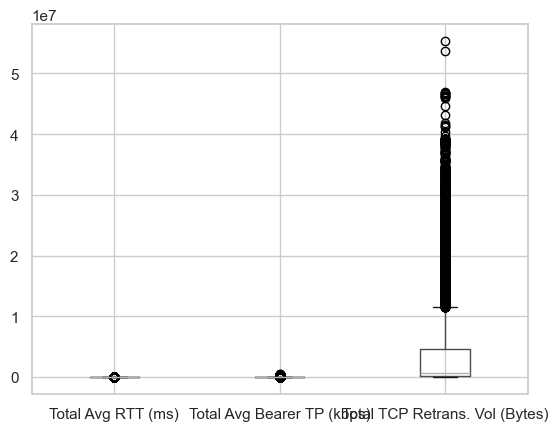

In [41]:
df_tele_user_experience_agg_new.boxplot()


In [42]:
#Overview of user_experience metrics
df_tele_user_experience_agg_new = df_tele_user_experience_agg_new[["Total Avg RTT (ms)",
    "Total Avg Bearer TP (kbps)",
    "Total TCP Retrans. Vol (Bytes)"]]
my_util = Util(df_tele_user_experience_agg_new)
my_util.getOverview(["Total Avg RTT (ms)",
    "Total Avg Bearer TP (kbps)",
    "Total TCP Retrans. Vol (Bytes)"])

Name of columns,Total Avg Bearer TP (kbps),Total Avg RTT (ms),Total TCP Retrans. Vol (Bytes)
Min,0.0,0.0,51.0
Q1,97.0,39.0,83894.25
Median,302.0,64.0,702503.5
Q3,25398.625,118.0,4669298.0
Max,445187.0,1270.0,55343222.0
IQR,25301.625,79.0,4585403.75
Lower fence,-37855.4375,-79.5,-6794211.375
Upper fence,63351.0625,236.5,11547403.625
Skew,3.269035,3.429897,2.762732
Number_of_outliers,4950,4572,3612


In [43]:
# replace outliers in specified columns of a DataFrame with the upper and lower fences.
my_util.replace_outliers_with_fences(["Total Avg RTT (ms)",
    "Total Avg Bearer TP (kbps)",
    "Total TCP Retrans. Vol (Bytes)"])
my_util.getOverview(["Total Avg RTT (ms)",
    "Total Avg Bearer TP (kbps)",
    "Total TCP Retrans. Vol (Bytes)"])

Name of columns,Total Avg RTT (ms),Total Avg Bearer TP (kbps),Total TCP Retrans. Vol (Bytes)
Min,0.0,0.0,51.0
Q1,39.0,97.0,83894.25
Median,64.0,302.0,702503.5
Q3,118.0,25398.625,4669298.0
Max,236.5,63351.0625,11547403.625
IQR,79.0,25301.625,4585403.75
Lower fence,-79.5,-37855.4375,-6794211.375
Upper fence,236.5,63351.0625,11547403.625
Skew,1.207379,1.215236,1.16677
Number_of_outliers,0,0,0


<Axes: >

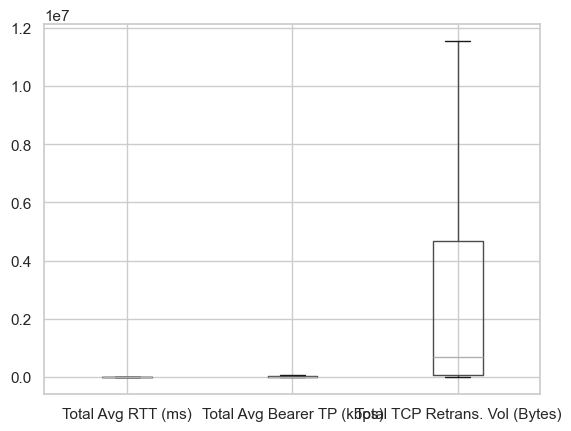

In [45]:
df_tele_user_experience_agg_new.boxplot()

KMeans Clustering

Scaling Data

In [47]:
# Instantiate StandardScaler:
scaler_instance = StandardScaler()
# Fit and Transform:
scaled_data = scaler_instance.fit_transform(df_tele_user_experience_agg_new)
scaled_data

array([[-0.65952504, -0.67835113,  0.07920927],
       [-0.93056783, -0.67723988,  1.48635664],
       [-0.4246213 , -0.67733651,  0.44785616],
       ...,
       [-0.55110793, -0.18123297, -0.70722444],
       [-0.76794216, -0.67641851, -0.69843053],
       [-0.40655178, -0.6804287 , -0.73584885]])

Normalize Data

In [48]:
normalized_data = normalize(scaled_data)
normalized_data

array([[-0.69465741, -0.71448635,  0.08342868],
       [-0.49502025, -0.36026117,  0.79067492],
       [-0.46339275, -0.73918295,  0.48874914],
       ...,
       [-0.60248125, -0.1981272 , -0.77315067],
       [-0.61981584, -0.54594595, -0.56371212],
       [-0.37589885, -0.62912617, -0.68036779]])

In [49]:
# Instantiate and Fit KMeans Retrieve Cluster Labels:
kmeans = KMeans(n_clusters=3, random_state=1).fit(normalized_data)
kmeans.labels_

array([1, 2, 2, ..., 1, 1, 1])

In [50]:
# inserting a new column labeled 'cluster' into the DataFrame 
df_tele_user_experience_agg_new.insert(0, 'cluster', kmeans.labels_)
df_tele_user_experience_agg_new

,cluster,Total Avg RTT (ms),Total Avg Bearer TP (kbps),Total TCP Retrans. Vol (Bytes)
MSISDN/Number,,,,
33601001722,1,46.0,76.0,2895381.0
33601001754,2,31.0,99.0,7685875.5
33601002511,2,59.0,97.0,4150403.0
33601007832,1,84.0,248.0,2396.0
33601008617,0,119.0,43204.5,8047304.5
...,...,...,...,...
33789967113,1,53.0,67.0,56578.0
33789980299,0,109.0,52859.0,7835020.5
33789996170,1,52.0,10365.0,218045.0


In [51]:
df_tele_user_experience_agg_new['cluster'].value_counts()


cluster
1    53833
0    33124
2    18759
Name: count, dtype: int64

In [ ]:
#ADD PLOT
#ADD PLOT

In [52]:
# summary of the statistical information for data points belonging to cluster 0
cluster0 = df_tele_user_experience_agg_new[df_tele_user_experience_agg_new["cluster"]==0]
cluster0[["Total Avg RTT (ms)",
    "Total Avg Bearer TP (kbps)",
    "Total TCP Retrans. Vol (Bytes)"]].describe()



,Total Avg RTT (ms),Total Avg Bearer TP (kbps),Total TCP Retrans. Vol (Bytes)
count,33124.000000,33124.000000,3.312400e+04
mean,127.225939,39952.605615,3.598857e+06
std,61.637529,18020.431925,3.762220e+06
min,19.000000,2.000000,9.700000e+01
25%,77.000000,27085.500000,4.182932e+05
50%,121.000000,44194.750000,1.959490e+06
75%,164.500000,52765.000000,7.230007e+06
max,236.500000,63351.062500,1.154740e+07


In [53]:
# summary of the statistical information for data points belonging to cluster 1
cluster1 = df_tele_user_experience_agg_new[df_tele_user_experience_agg_new["cluster"]==1]
cluster1[["Total Avg RTT (ms)",
    "Total Avg Bearer TP (kbps)",
    "Total TCP Retrans. Vol (Bytes)"]].describe()

,Total Avg RTT (ms),Total Avg Bearer TP (kbps),Total TCP Retrans. Vol (Bytes)
count,53833.000000,53833.000000,5.383300e+04
mean,57.448052,2044.395956,4.652163e+05
std,32.162430,4959.241139,7.187048e+05
min,0.000000,0.000000,5.100000e+01
25%,33.000000,85.000000,2.485700e+04
50%,48.000000,111.000000,1.302620e+05
75%,71.000000,522.000000,5.477380e+05
max,155.000000,32123.000000,3.710590e+06


In [54]:
# summary of the statistical information for data points belonging to cluster 2
cluster2 = df_tele_user_experience_agg_new[df_tele_user_experience_agg_new["cluster"]==2]
cluster2[["Total Avg RTT (ms)",
    "Total Avg Bearer TP (kbps)",
    "Total TCP Retrans. Vol (Bytes)"]].describe()

,Total Avg RTT (ms),Total Avg Bearer TP (kbps),Total TCP Retrans. Vol (Bytes)
count,18759.000000,18759.000000,1.875900e+04
mean,75.412575,3136.859694,7.107425e+06
std,46.901711,7261.046806,1.920259e+06
min,0.000000,0.000000,2.348164e+06
25%,38.000000,91.000000,5.974352e+06
50%,62.000000,125.000000,7.688262e+06
75%,107.000000,701.500000,7.824924e+06
max,236.500000,52981.000000,1.154740e+07


Save The Dataframe and Model

In [55]:
df_tele_user_experience_agg_new.to_csv('../data/tele_user_experience_data.csv')


In [56]:
with open("../models/tele_user_experience.pkl", "wb") as f:
    pickle.dump(kmeans, f)
